In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches
import seaborn as sns
sns.set_theme()
import pandas as pd
import mne
from scipy.fftpack import fft
from numpy.fft import rfft, irfft, rfftfreq
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from meegkit import dss, ress
from meegkit import sns as msns
from meegkit.utils import unfold, rms, fold, tscov, matmul3d, snr_spectrum
from brainda.paradigms import SSVEP
from brainda.algorithms.utils.model_selection import (
    set_random_seeds, 
    generate_loo_indices, match_loo_indices)
from brainda.algorithms.decomposition import (
    FBTRCA, FBTDCA, FBSCCA, FBECCA, FBDSP,
    generate_filterbank, generate_cca_references)
from collections import OrderedDict
import numpy as np
from scipy.signal import sosfiltfilt
from sklearn.pipeline import clone
from sklearn.metrics import balanced_accuracy_score

c:\Users\simon\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def load_data_temp_function(eeg, meta, classes, stim_duration=5, filter=True):
    trials = meta[1:,:2]
    times = meta[:,2]
    times = (times - times[0])[1:]
    eeg['time'] = eeg['time'] - eeg['time'].iloc[0]
    # eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[:1725].T for t in times])[:,:,225:]
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time']).to_numpy()[:1725].T for t in times])[:,:,225:]
    if filter:
        eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
    # eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir',phase='minimum')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

In [20]:
data_path = "../data/eeg_recordings/pilot_data/ws_demo1/6-21-22_run1/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 4, 7, 1500), (5, 4, 2))

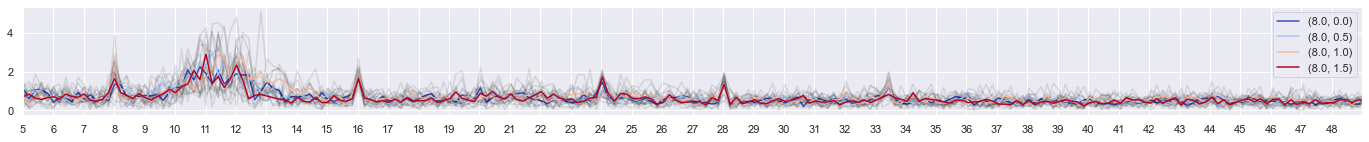

In [22]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,4))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

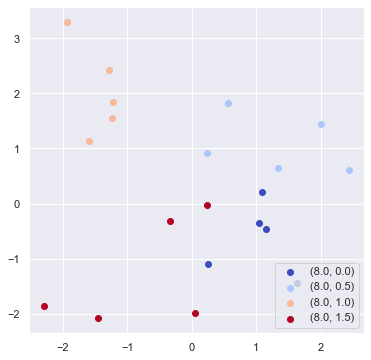

In [24]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(1):
    k *= 4
    plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
    ax.legend(loc='lower right')

In [25]:
data_path = "../data/eeg_recordings/pilot_data/ws_demo1/6-21-22_run2/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 4, 7, 1500), (5, 4, 2))

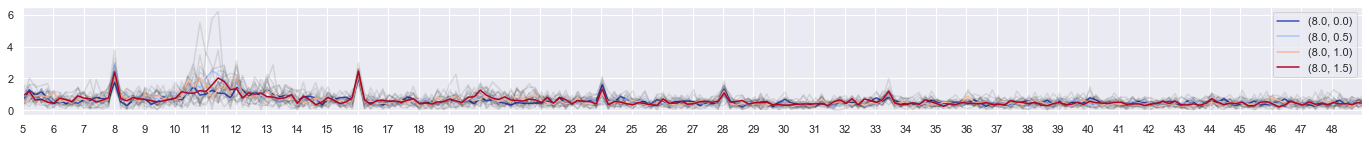

In [26]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,4))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

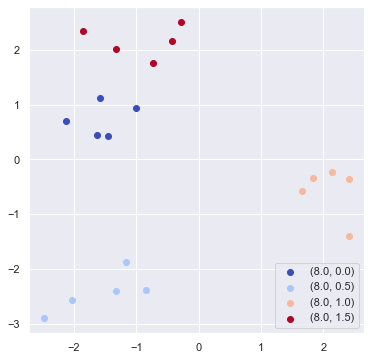

In [27]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(1):
    k *= 4
    plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
    ax.legend(loc='lower right')

In [3]:
data_path = "../data/eeg_recordings/pilot_data/ws_demo1/6-21-22_run3/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 4, 7, 1500), (5, 4, 2))

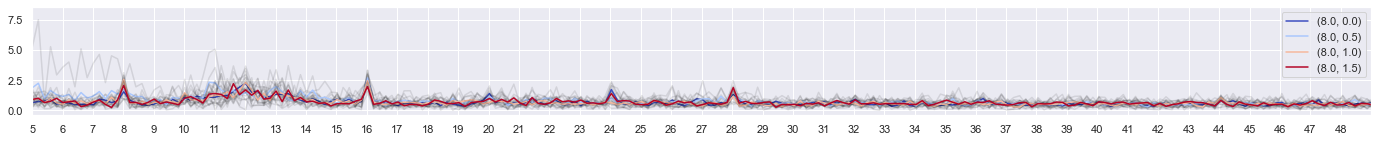

In [4]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,4))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

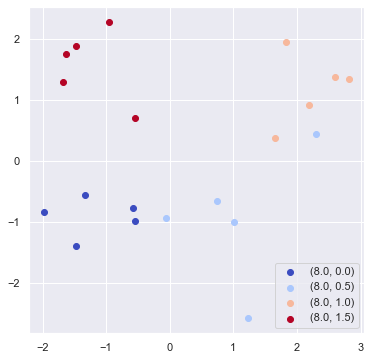

In [5]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(1):
    k *= 4
    plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
    ax.legend(loc='lower right')

In [6]:
data_path = "../data/eeg_recordings/pilot_data/ws_demo1/6-21-22_run4/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 4, 7, 1500), (5, 4, 2))

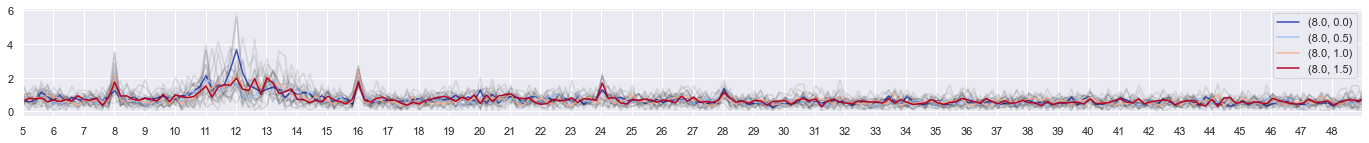

In [7]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,4))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

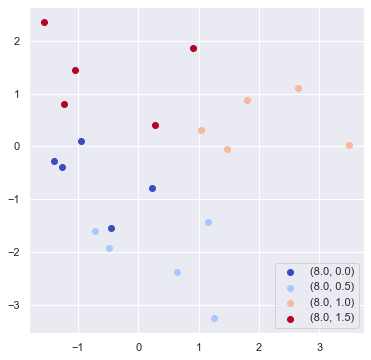

In [8]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(1):
    k *= 4
    plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
    ax.legend(loc='lower right')

In [9]:
data_path = "../data/eeg_recordings/pilot_data/ws_demo1/6-21-22_run5/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 4, 7, 1500), (5, 4, 2))

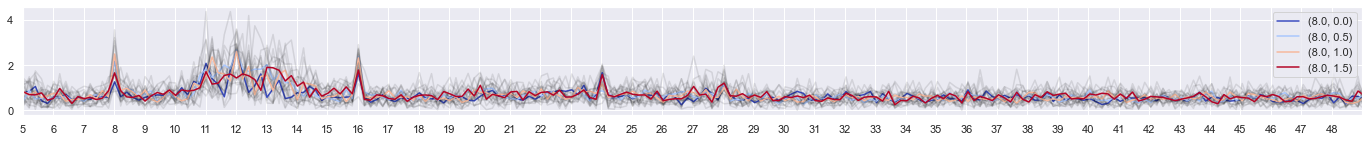

In [10]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,4))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

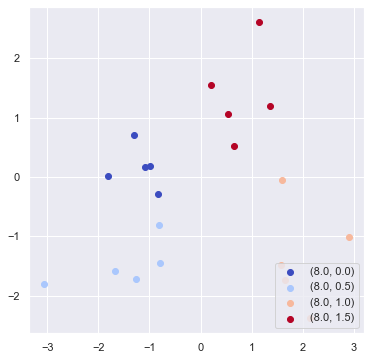

In [11]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(1):
    k *= 4
    plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
    ax.legend(loc='lower right')

In [15]:
data_path = "../data/eeg_recordings/pilot_data/ws_demo1/6-21-22_run7/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 4, 8, 1500), (5, 4, 2))

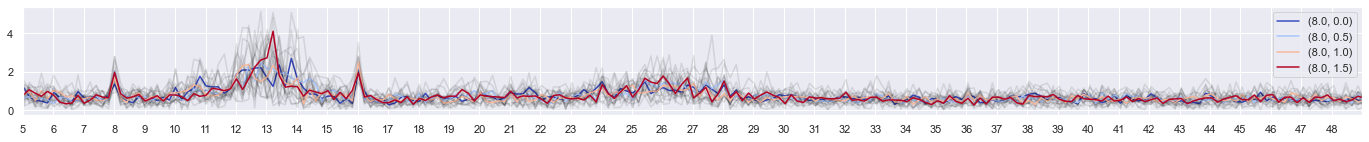

In [20]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,4))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

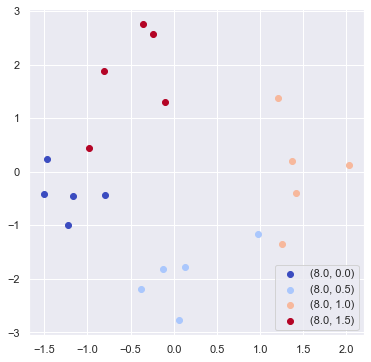

In [17]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(1):
    k *= 4
    plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
    ax.legend(loc='lower right')

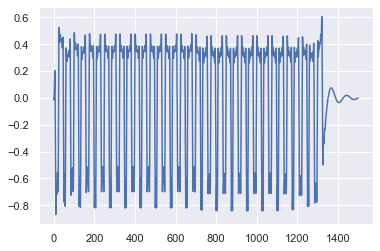

In [21]:
plt.plot(eeg[0,0,7,:])

In [ ]:
def load_data_temp_function(eeg, meta, classes, stim_duration=5, filter=True):
    trials = meta[1:,:2]
    times = meta[:,2]
    times = (times - times[0])[1:]
    eeg['time'] = eeg['time'] - eeg['time'].iloc[0]
    # eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[:1725].T for t in times])[:,:,225:]
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time']).to_numpy()[:1725].T for t in times])[:,:,225:]
    if filter:
        eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
    # eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir',phase='minimum')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

In [23]:
data_path = "../data/eeg_recordings/pilot_data/ws_timing_test/dsi7_8hz_1/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)

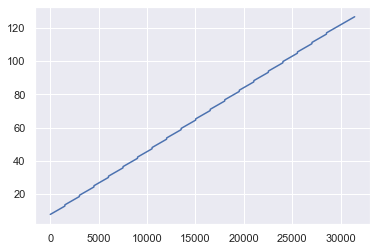

In [29]:
plt.plot(np.array(eeg.loc[eeg[' TRG']==1]['time']))

In [31]:
eeg[' TRG']==0

0         True
1         True
2         True
3         True
4         True
         ...  
37795    False
37796    False
37797    False
37798    False
37799    False
Name:  TRG, Length: 37800, dtype: bool

In [32]:
data_path = "../data/eeg_recordings/pilot_data/ws_demo1/6-21-22_run8/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 4, 28, 1500), (5, 4, 2))

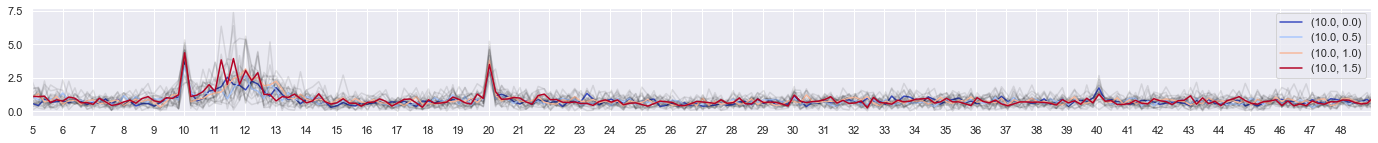

In [54]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,4))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,13,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,13,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

In [56]:
data_path = "../data/eeg_recordings/pilot_data/ws_timing_test/dsi24_8hz_1/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)

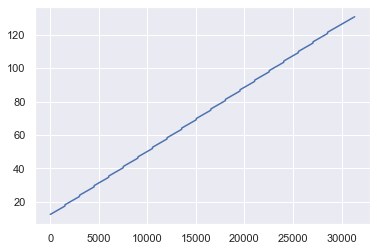

In [57]:
plt.plot(np.array(eeg.loc[eeg[' TRG']==1]['time']))

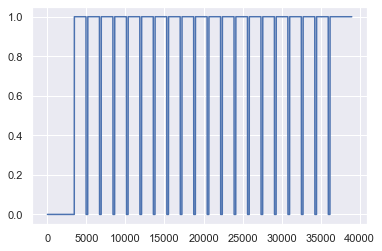

In [58]:
plt.plot(eeg[' TRG'])

In [70]:
times = []
for index, row in eeg.loc[eeg[' TRG']==1].iterrows():
    if eeg.iloc[index-1][' TRG'] == 0:
        # print(row['time'])
        times.append(row['time'])
times = np.array(times)
times.shape

(20,)

In [82]:
data_path = "../data/eeg_recordings/pilot_data/ws_timing_test/dsi24_8hz_1/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 4, 28, 1500), (5, 4, 2))

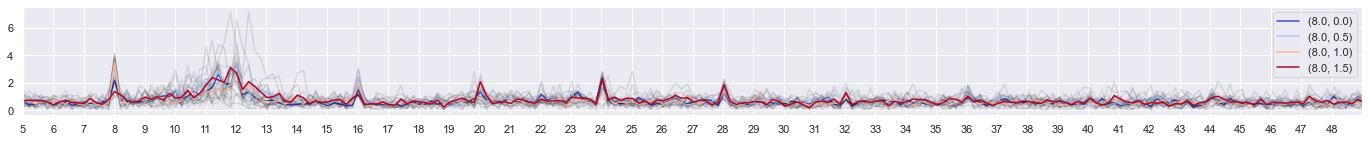

In [83]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,4))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,13,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,13,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

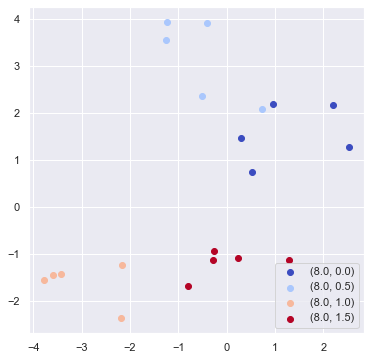

In [84]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(1):
    k *= 4
    plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        plt.scatter(np.real(complex_spectrum[:,i,13,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,13,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
    ax.legend(loc='lower right')

In [85]:
data_path = "../data/eeg_recordings/pilot_data/ws_timing_test/dsi7_8hz_1/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 4, 8, 1500), (5, 4, 2))

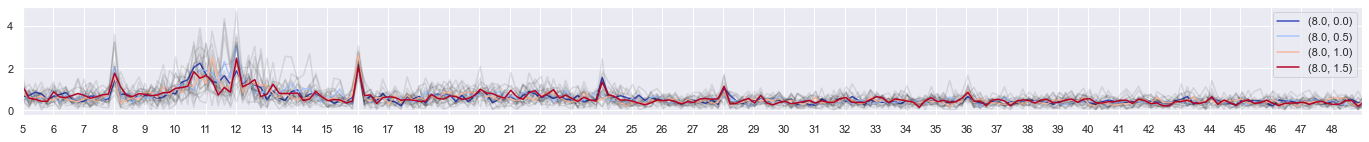

In [86]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,4))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

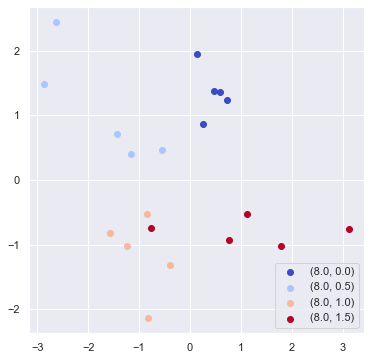

In [87]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(1):
    k *= 4
    plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
    ax.legend(loc='lower right')

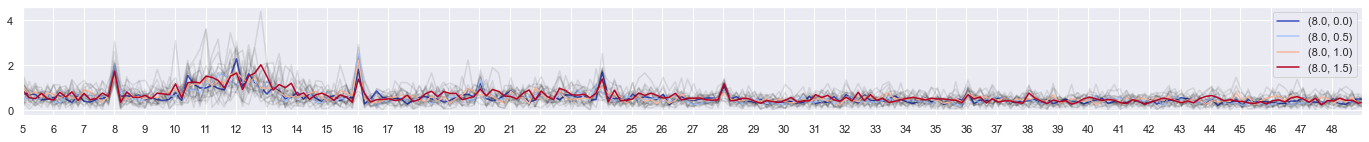

In [89]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,4))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

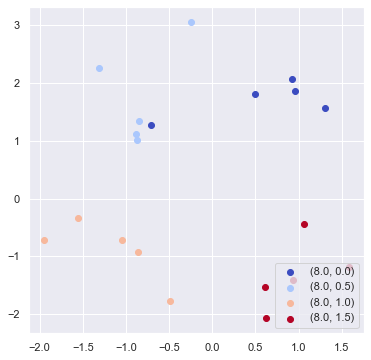

In [90]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(1):
    k *= 4
    plt.figure(figsize=(6, 6))
    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i
        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)
    ax.legend(loc='lower right')

In [88]:
data_path = "../data/eeg_recordings/pilot_data/ws_timing_test/dsi7_8hz_2/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 4, 8, 1500), (5, 4, 2))

In [97]:
data_path = "../data/eeg_recordings/pilot_data/ws_timing_test/dsi24_12hz_1/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)           
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

IndexError: index 18 is out of bounds for axis 0 with size 18

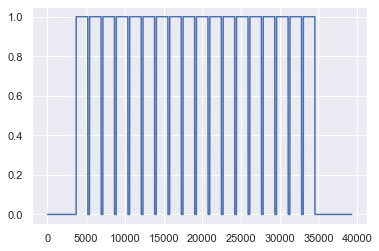

In [98]:
plt.plot(eeg[' TRG'])

In [100]:
times = []
for index, row in eeg.loc[eeg[' TRG']==1].iterrows():
    if eeg.iloc[index-1][' TRG'] == 0:
        # print(row['time'])
        times.append(row['time'])
times = np.array(times)
times.shape

(18,)

In [6]:
data_path = "../data/eeg_recordings/pilot_data/ws_timing_test/dsi24_15hz_2/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

C:\Users\simon\AppData\Local\Temp\ipykernel_3624\416462828.py:14: RuntimeWarning: filter_length (495) is longer than the signal (0), distortion is likely. Reduce filter length or filter a longer signal.
  eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')


IndexError: index 0 is out of bounds for axis 0 with size 0

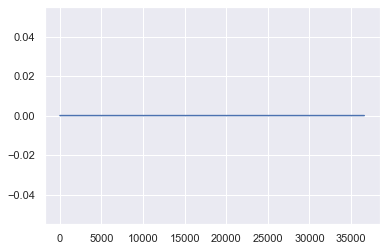

In [7]:
plt.plot(eeg[' TRG'])

In [3]:
def load_data_temp_function(eeg, meta, classes, stim_duration=5, filter=True):
    trials = meta[1:,:2]
    times = []
    for index, row in eeg.loc[eeg[' TRG']==1].iterrows():
        if eeg.iloc[index-1][' TRG'] == 0 and index > 1000:
            # print(row['time'])
            times.append(row['time'])
    times = np.array(times)
    # eeg['time'] = eeg['time'] - eeg['time'].iloc[0]
    # eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[:1725].T for t in times])[:,:,225:]
    # eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time']).to_numpy()[:1725].T for t in times])[:,:,225:]
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[:1500].T for t in times])
    if filter:
        eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
    # eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir',phase='minimum')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

In [2]:
def load_data_temp_function(eeg, meta, classes, stim_duration=5, filter=True):
    trials = meta[1:,:2]
    times = []
    for index, row in eeg.loc[eeg[' TRG']==1].iterrows():
        if eeg.iloc[index-1][' TRG'] == 0:
            # print(row['time'])
            times.append(row['time'])
    times = np.array(times)
    # eeg['time'] = eeg['time'] - eeg['time'].iloc[0]
    # eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[:1725].T for t in times])[:,:,225:]
    # eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time']).to_numpy()[:1725].T for t in times])[:,:,225:]
    eeg = np.array([eeg.loc[eeg['time']>t].drop(columns=['time',' TRG']).to_numpy()[:1500].T for t in times])
    if filter:
        eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir')
    # eeg = mne.filter.filter_data(eeg, sfreq=300, l_freq=5, h_freq=49, verbose=0, method='fir',phase='minimum')
    eeg_temp = []
    for i in range(len(classes)):
        eeg_temp.append([])
    for i,freq in enumerate(trials):
        for j,target in enumerate(classes):
            if (freq==target).all():
                eeg_temp[j].append(eeg[i])
    eeg = np.array(eeg_temp).transpose(1,0,2,3)
    return eeg

In [28]:
data_path = "../data/eeg_recordings/pilot_data/simon/ws32_1/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 32, 7, 1500), (5, 32, 2))

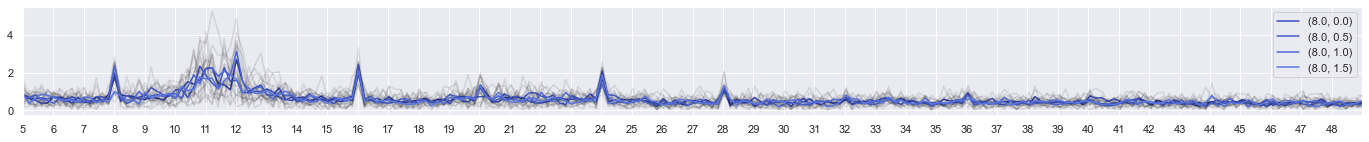

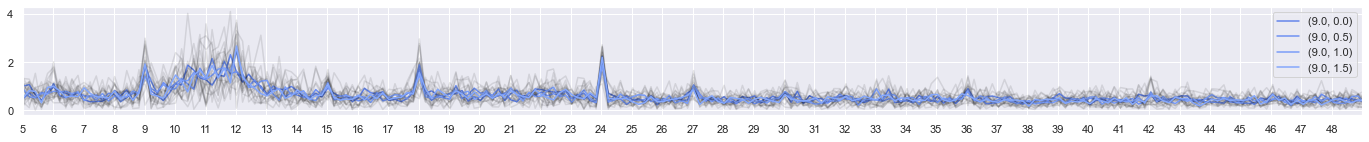

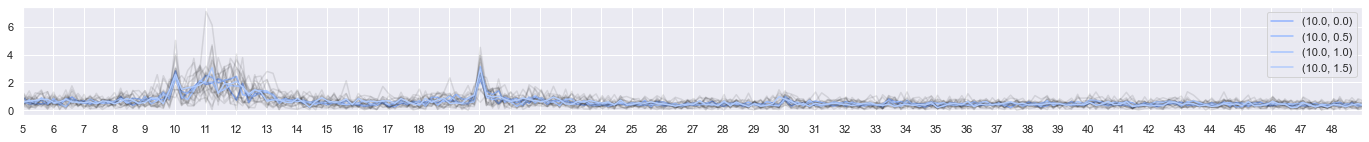

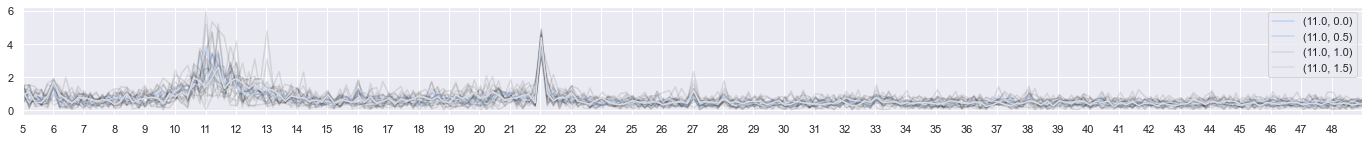

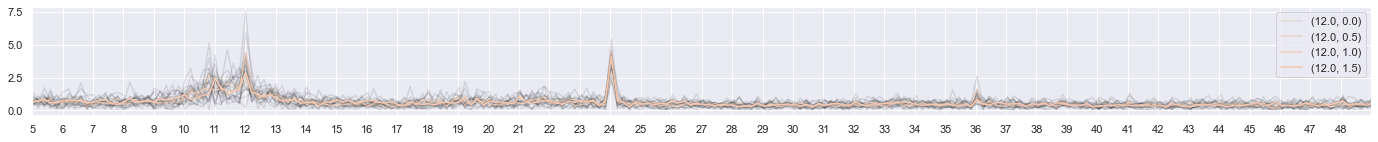

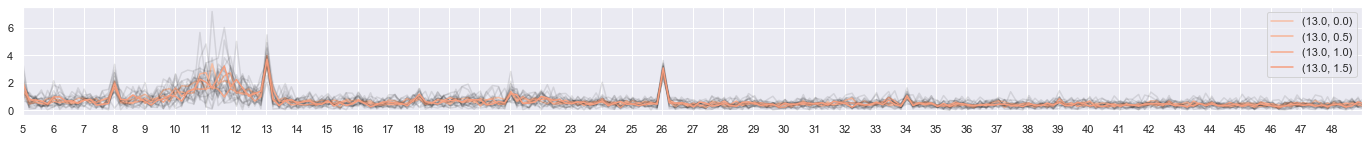

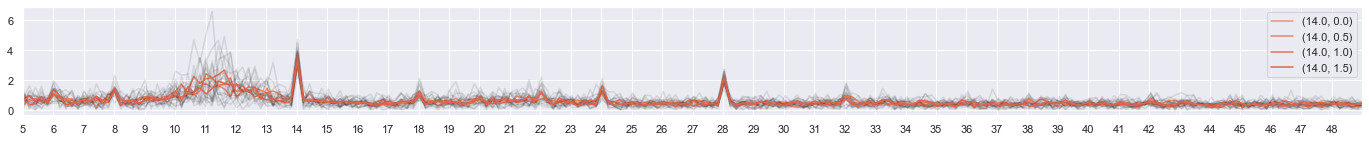

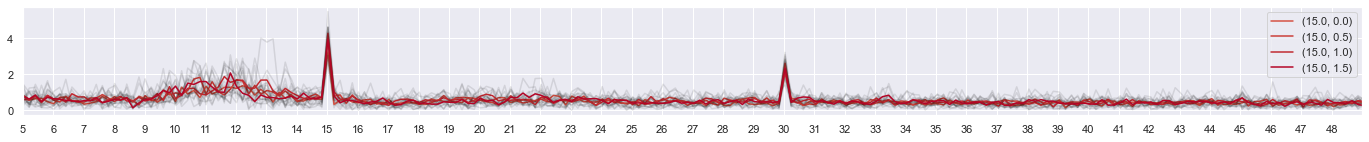

In [29]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,32))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

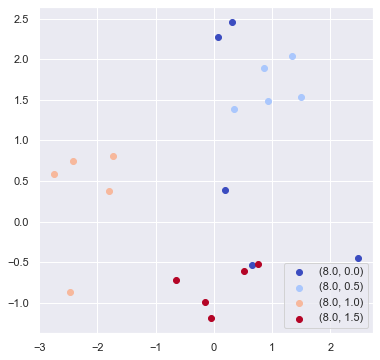

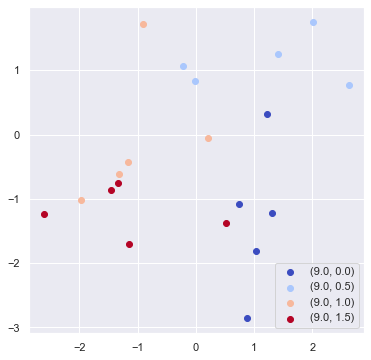

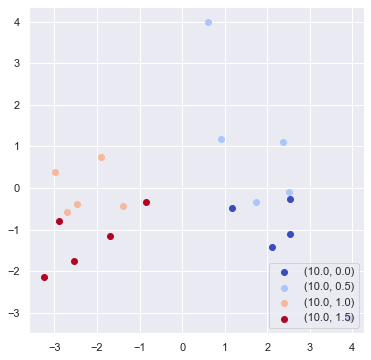

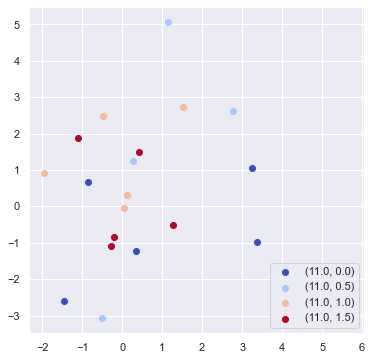

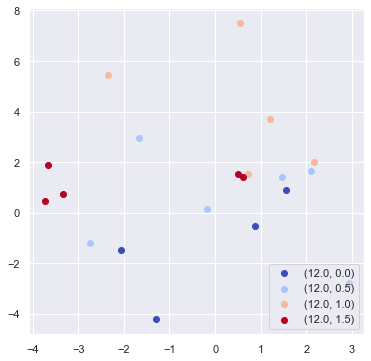

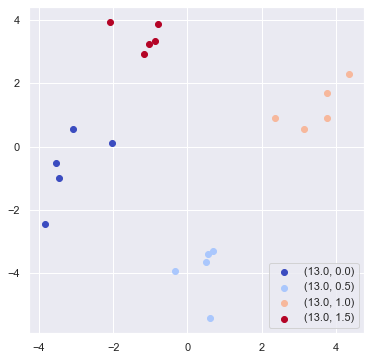

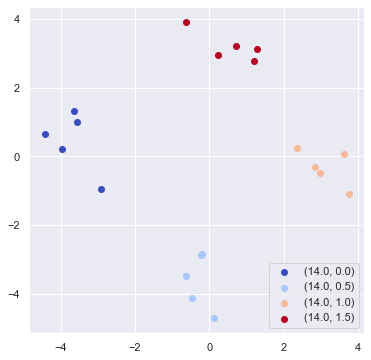

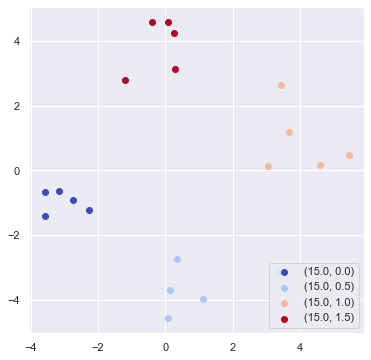

In [30]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(8):
    k *= 4
    plt.figure(figsize=(6, 6))

    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i

        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)

    ax.legend(loc='lower right')

In [46]:
y = np.array([list(target_tab.values())] * 5).T.reshape(-1)
eeg_temp = eeg[:,:,:,40:]
# X = eeg.swapaxes(0,1).reshape(-1,*eeg.shape[2:])
X = eeg_temp.swapaxes(0,1).reshape(-1,*eeg_temp.shape[2:])

freq_targets = np.array(target_by_trial)[0,:,0]
phase_targets = np.array(target_by_trial)[0,:,1]
n_harmonics = 5
n_bands = 3
srate = 300
duration = 2
Yf = generate_cca_references(
    freq_targets, srate, duration, 
    phases=phase_targets, 
    n_harmonics=n_harmonics)
wp = [[8*i, 90] for i in range(1, n_bands+1)]
ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
filterbank = generate_filterbank(
    wp, ws, srate, order=4, rp=1)
filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
set_random_seeds(64)
l = 3
models = OrderedDict([
    ('fbscca', FBSCCA(
            filterbank, filterweights=filterweights)),
    ('fbecca', FBECCA(
            filterbank, filterweights=filterweights)),
    ('fbdsp', FBDSP(
            filterbank, filterweights=filterweights)),
    ('fbtrca', FBTRCA(
            filterbank, filterweights=filterweights)),
    ('fbtdca', FBTDCA(
            filterbank, l, n_components=8, 
            filterweights=filterweights)),
])
events = []
for j_class in range(32):
    events.extend([str(target_by_trial[i_trial][j_class]) for i_trial in range(5)])
events = np.array(events)
subjects = ['1'] * (32*5)
meta = pd.DataFrame(data=np.array([subjects,events]).T, columns=["subject", "event"])
set_random_seeds(42)
loo_indices = generate_loo_indices(meta)

for model_name in models:
    if model_name == 'fbtdca':
        filterX, filterY = np.copy(X[..., :int(srate*duration)+l]), np.copy(y)
    else:
        filterX, filterY = np.copy(X[..., :int(srate*duration)]), np.copy(y)
    
    filterX = filterX - np.mean(filterX, axis=-1, keepdims=True)

    n_loo = len(loo_indices['1'][events[0]])
    loo_accs = []
    for k in range(n_loo):
        train_ind, validate_ind, test_ind = match_loo_indices(
            k, meta, loo_indices)
        train_ind = np.concatenate([train_ind, validate_ind])

        trainX, trainY = filterX[train_ind], filterY[train_ind]
        testX, testY = filterX[test_ind], filterY[test_ind]

        model = clone(models[model_name]).fit(
            trainX, trainY,
            Yf=Yf
        )
        pred_labels = model.predict(testX)
        loo_accs.append(
            balanced_accuracy_score(testY, pred_labels))
    print("Model:{} LOO Acc:{:.2f}".format(model_name, np.mean(loo_accs)))

Model:fbscca LOO Acc:0.14
Model:fbecca LOO Acc:0.84
Model:fbdsp LOO Acc:0.94
Model:fbtrca LOO Acc:0.95
Model:fbtdca LOO Acc:0.97


In [26]:
times.shape

(160,)

In [35]:
events.shape

(160,)

In [47]:
data_path = "../data/eeg_recordings/pilot_data/simon/wsx32_1/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 32, 23, 1500), (5, 32, 2))

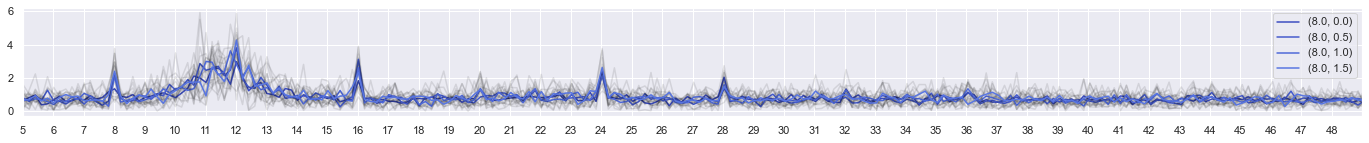

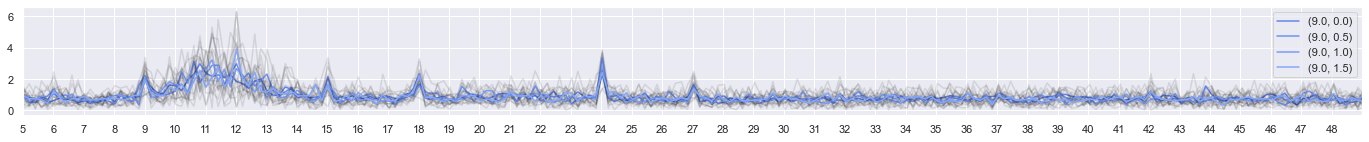

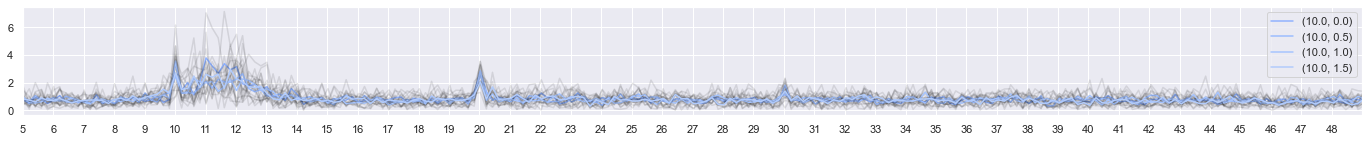

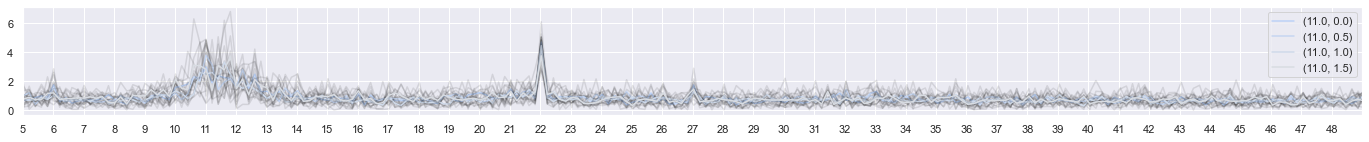

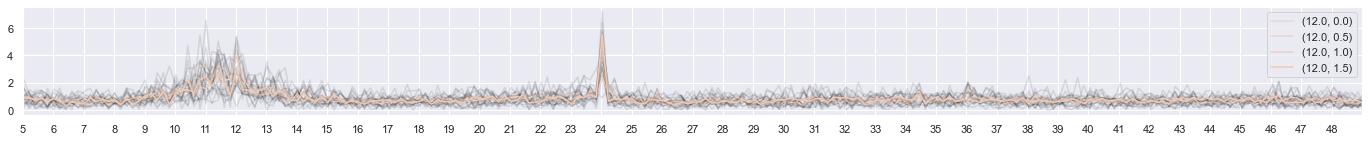

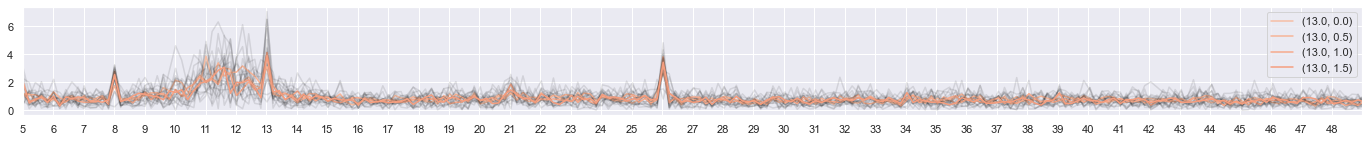

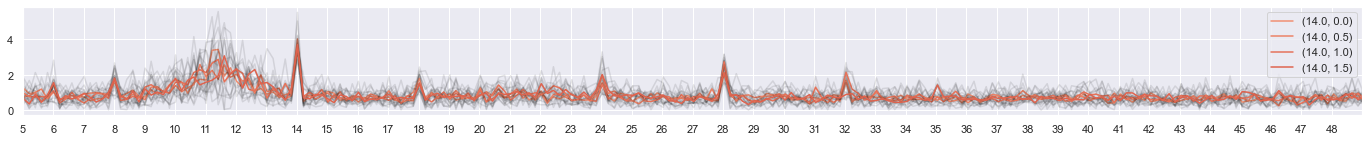

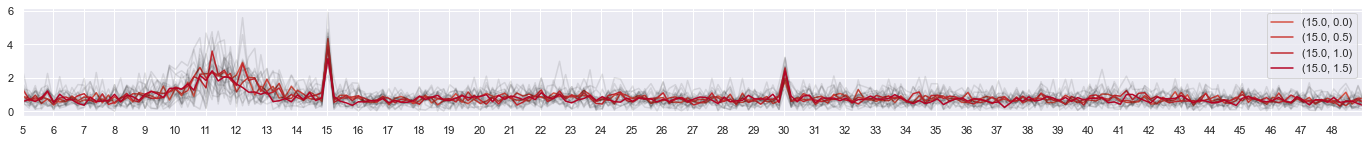

In [48]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,32))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,13,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,13,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

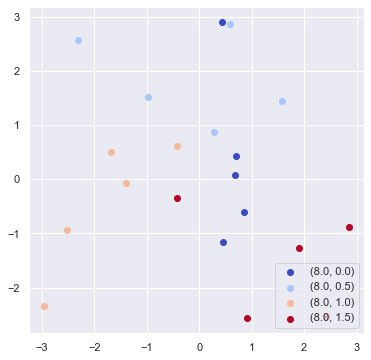

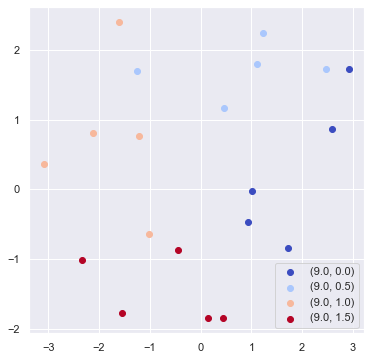

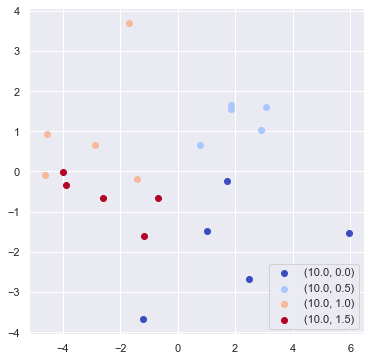

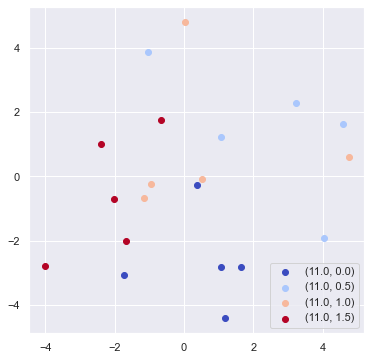

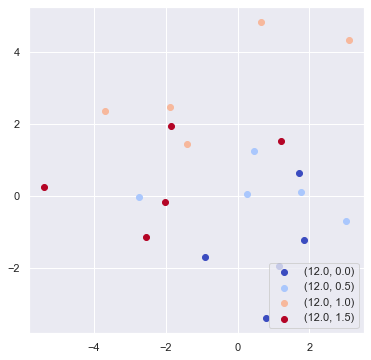

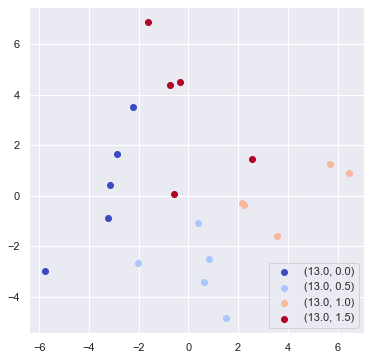

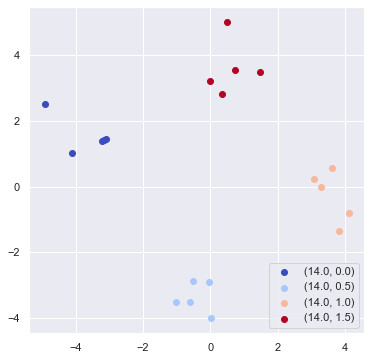

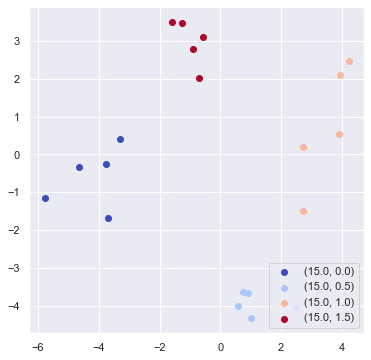

In [49]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(8):
    k *= 4
    plt.figure(figsize=(6, 6))

    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i

        plt.scatter(np.real(complex_spectrum[:,i,13,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,13,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)

    ax.legend(loc='lower right')

In [59]:
y = np.array([list(target_tab.values())] * 5).T.reshape(-1)
eeg_temp = eeg[:,:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,18,21,22],40:]
# X = eeg.swapaxes(0,1).reshape(-1,*eeg.shape[2:])
X = eeg_temp.swapaxes(0,1).reshape(-1,*eeg_temp.shape[2:])

freq_targets = np.array(target_by_trial)[0,:,0]
phase_targets = np.array(target_by_trial)[0,:,1]
n_harmonics = 5
n_bands = 3
srate = 300
duration = 1.5
Yf = generate_cca_references(
    freq_targets, srate, duration, 
    phases=phase_targets, 
    n_harmonics=n_harmonics)
wp = [[8*i, 90] for i in range(1, n_bands+1)]
ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
filterbank = generate_filterbank(
    wp, ws, srate, order=4, rp=1)
filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
set_random_seeds(64)
l = 3
models = OrderedDict([
    ('fbscca', FBSCCA(
            filterbank, filterweights=filterweights)),
    ('fbecca', FBECCA(
            filterbank, filterweights=filterweights)),
    ('fbdsp', FBDSP(
            filterbank, filterweights=filterweights)),
    ('fbtrca', FBTRCA(
            filterbank, filterweights=filterweights)),
    ('fbtdca', FBTDCA(
            filterbank, l, n_components=8, 
            filterweights=filterweights)),
])
events = []
for j_class in range(32):
    events.extend([str(target_by_trial[i_trial][j_class]) for i_trial in range(5)])
events = np.array(events)
subjects = ['1'] * (32*5)
meta = pd.DataFrame(data=np.array([subjects,events]).T, columns=["subject", "event"])
set_random_seeds(42)
loo_indices = generate_loo_indices(meta)

for model_name in models:
    if model_name == 'fbtdca':
        filterX, filterY = np.copy(X[..., :int(srate*duration)+l]), np.copy(y)
    else:
        filterX, filterY = np.copy(X[..., :int(srate*duration)]), np.copy(y)
    
    filterX = filterX - np.mean(filterX, axis=-1, keepdims=True)

    n_loo = len(loo_indices['1'][events[0]])
    loo_accs = []
    for k in range(n_loo):
        train_ind, validate_ind, test_ind = match_loo_indices(
            k, meta, loo_indices)
        train_ind = np.concatenate([train_ind, validate_ind])

        trainX, trainY = filterX[train_ind], filterY[train_ind]
        testX, testY = filterX[test_ind], filterY[test_ind]

        model = clone(models[model_name]).fit(
            trainX, trainY,
            Yf=Yf
        )
        pred_labels = model.predict(testX)
        loo_accs.append(
            balanced_accuracy_score(testY, pred_labels))
    print("Model:{} LOO Acc:{:.2f}".format(model_name, np.mean(loo_accs)))

Model:fbscca LOO Acc:0.08
Model:fbecca LOO Acc:0.56
Model:fbdsp LOO Acc:0.86
Model:fbtrca LOO Acc:0.88
Model:fbtdca LOO Acc:0.95


In [55]:
eeg_temp = eeg[:,:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,18,21,22],40:]
eeg_temp.shape

(5, 32, 19, 1460)

In [61]:
data_path = "../data/eeg_recordings/pilot_data/simon/wsx40_1/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 40, 23, 1500), (5, 40, 2))

In [63]:
y = np.array([list(target_tab.values())] * 5).T.reshape(-1)
eeg_temp = eeg[:,:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,17,18,21,22],40:]
# X = eeg.swapaxes(0,1).reshape(-1,*eeg.shape[2:])
X = eeg_temp.swapaxes(0,1).reshape(-1,*eeg_temp.shape[2:])

freq_targets = np.array(target_by_trial)[0,:,0]
phase_targets = np.array(target_by_trial)[0,:,1]
n_harmonics = 5
n_bands = 3
srate = 300
duration = 1.5
Yf = generate_cca_references(
    freq_targets, srate, duration, 
    phases=phase_targets, 
    n_harmonics=n_harmonics)
wp = [[8*i, 90] for i in range(1, n_bands+1)]
ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
filterbank = generate_filterbank(
    wp, ws, srate, order=4, rp=1)
filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
set_random_seeds(64)
l = 3
models = OrderedDict([
    ('fbscca', FBSCCA(
            filterbank, filterweights=filterweights)),
    ('fbecca', FBECCA(
            filterbank, filterweights=filterweights)),
    ('fbdsp', FBDSP(
            filterbank, filterweights=filterweights)),
    ('fbtrca', FBTRCA(
            filterbank, filterweights=filterweights)),
    ('fbtdca', FBTDCA(
            filterbank, l, n_components=8, 
            filterweights=filterweights)),
])
events = []
for j_class in range(40):
    events.extend([str(target_by_trial[i_trial][j_class]) for i_trial in range(5)])
events = np.array(events)
subjects = ['1'] * (40*5)
meta = pd.DataFrame(data=np.array([subjects,events]).T, columns=["subject", "event"])
set_random_seeds(42)
loo_indices = generate_loo_indices(meta)

for model_name in models:
    if model_name == 'fbtdca':
        filterX, filterY = np.copy(X[..., :int(srate*duration)+l]), np.copy(y)
    else:
        filterX, filterY = np.copy(X[..., :int(srate*duration)]), np.copy(y)
    
    filterX = filterX - np.mean(filterX, axis=-1, keepdims=True)

    n_loo = len(loo_indices['1'][events[0]])
    loo_accs = []
    for k in range(n_loo):
        train_ind, validate_ind, test_ind = match_loo_indices(
            k, meta, loo_indices)
        train_ind = np.concatenate([train_ind, validate_ind])

        trainX, trainY = filterX[train_ind], filterY[train_ind]
        testX, testY = filterX[test_ind], filterY[test_ind]

        model = clone(models[model_name]).fit(
            trainX, trainY,
            Yf=Yf
        )
        pred_labels = model.predict(testX)
        loo_accs.append(
            balanced_accuracy_score(testY, pred_labels))
    print("Model:{} LOO Acc:{:.2f}".format(model_name, np.mean(loo_accs)))

Model:fbscca LOO Acc:0.03
Model:fbecca LOO Acc:0.03


LinAlgError: The leading minor of order 9 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

In [18]:
data_path = "../data/eeg_recordings/pilot_data/simon/ws32_4/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

IndexError: index 159 is out of bounds for axis 0 with size 159

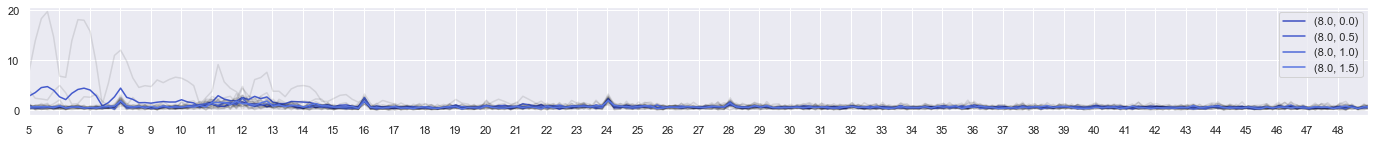

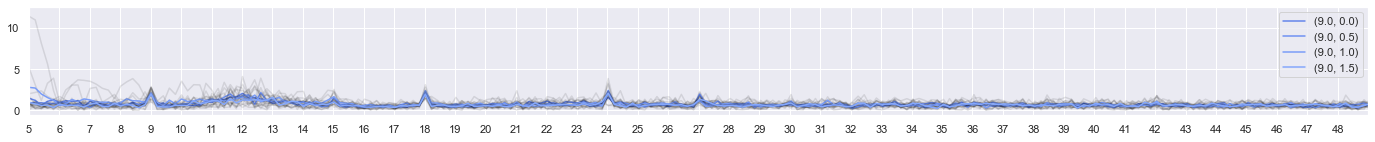

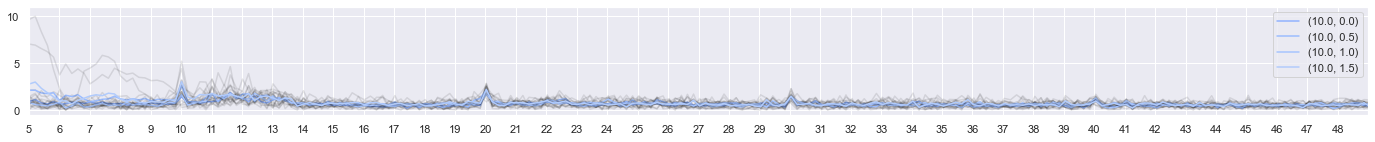

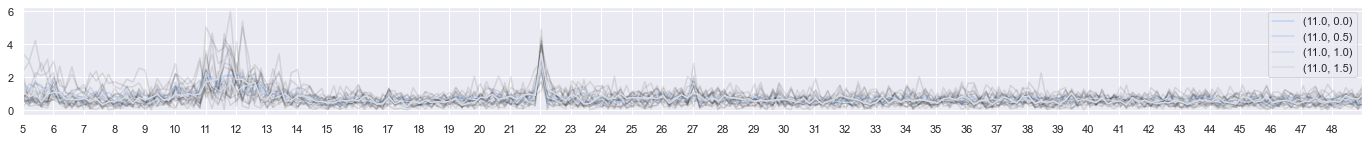

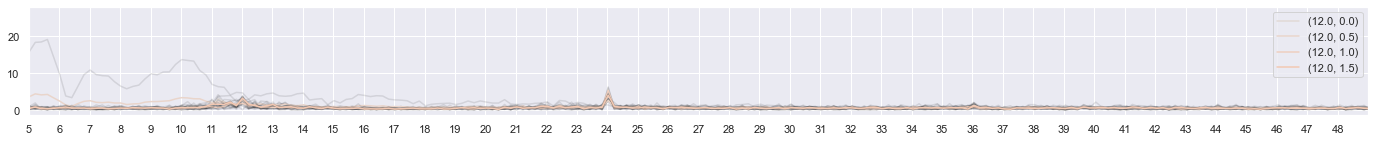

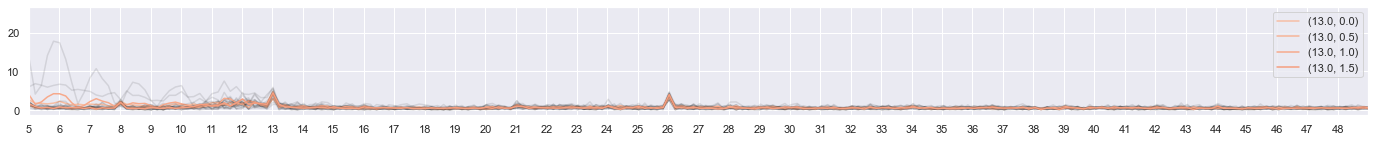

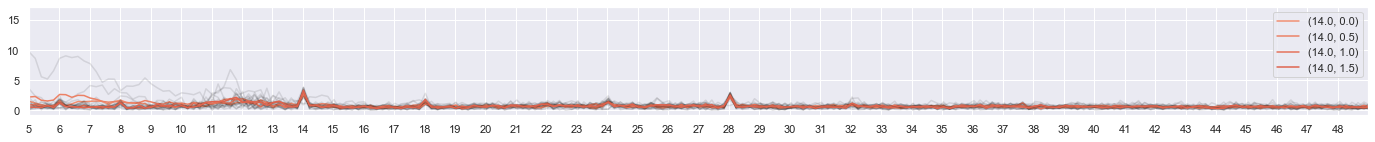

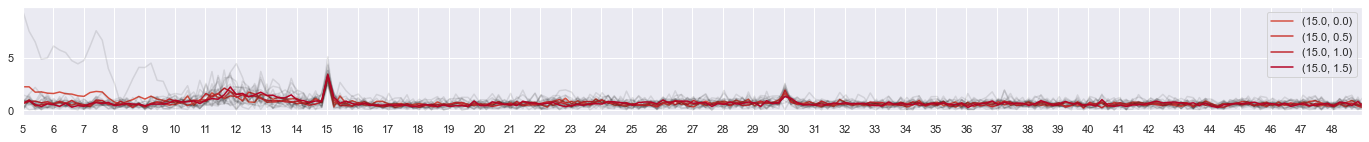

In [11]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,32))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

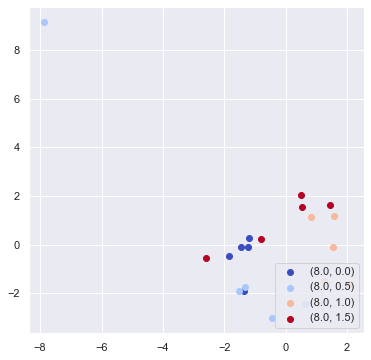

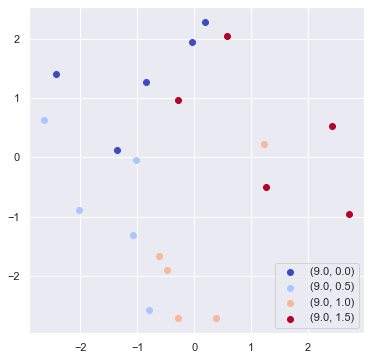

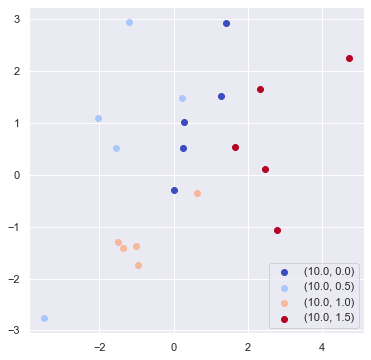

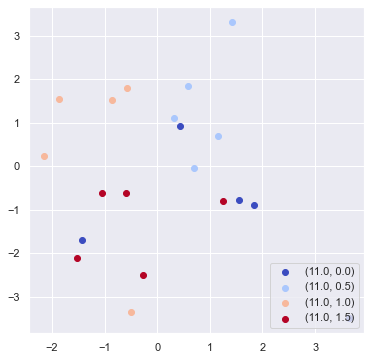

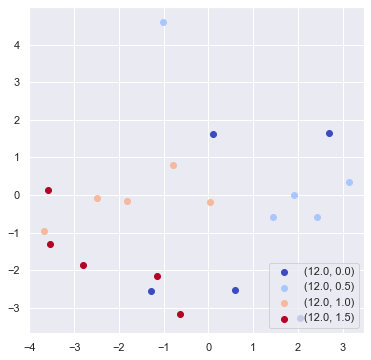

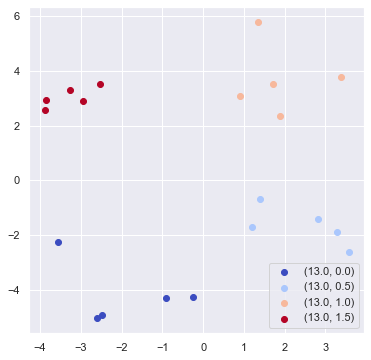

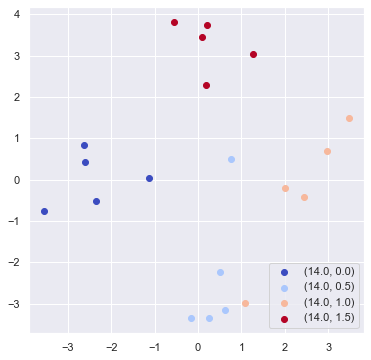

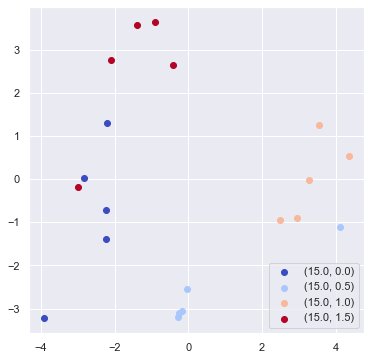

In [12]:
complex_spectrum = 1/750*fft(eeg)[:,:,:,:int(sfreq*duration)//2]
classes = list(target_tab.keys())
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
for k in range(8):
    k *= 4
    plt.figure(figsize=(6, 6))

    ax = plt.subplot()
    colors=cm.coolwarm(np.linspace(0,1,4))
    for i,c in enumerate(colors):
        i = k + i

        plt.scatter(np.real(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),np.imag(complex_spectrum[:,i,0,np.abs(freqs - classes[i][0]).argmin()]),label=str(classes[i]),color=c)

    ax.legend(loc='lower right')

In [17]:
y = np.array([list(target_tab.values())] * 5).T.reshape(-1)
eeg_temp = eeg[:,:,:,40:]
# X = eeg.swapaxes(0,1).reshape(-1,*eeg.shape[2:])
X = eeg_temp.swapaxes(0,1).reshape(-1,*eeg_temp.shape[2:])

freq_targets = np.array(target_by_trial)[0,:,0]
phase_targets = np.array(target_by_trial)[0,:,1]
n_harmonics = 5
n_bands = 3
srate = 300
duration = 3
Yf = generate_cca_references(
    freq_targets, srate, duration, 
    phases=phase_targets, 
    n_harmonics=n_harmonics)
wp = [[8*i, 90] for i in range(1, n_bands+1)]
ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
filterbank = generate_filterbank(
    wp, ws, srate, order=4, rp=1)
filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
set_random_seeds(64)
l = 3
models = OrderedDict([
    # ('fbscca', FBSCCA(
    #         filterbank, filterweights=filterweights)),
    # ('fbecca', FBECCA(
    #         filterbank, filterweights=filterweights)),
    ('fbdsp', FBDSP(
            filterbank, filterweights=filterweights)),
    ('fbtrca', FBTRCA(
            filterbank, filterweights=filterweights)),
    ('fbtdca', FBTDCA(
            filterbank, l, n_components=8, 
            filterweights=filterweights)),
])
events = []
for j_class in range(32):
    events.extend([str(target_by_trial[i_trial][j_class]) for i_trial in range(5)])
events = np.array(events)
subjects = ['1'] * (32*5)
meta = pd.DataFrame(data=np.array([subjects,events]).T, columns=["subject", "event"])
set_random_seeds(42)
loo_indices = generate_loo_indices(meta)

for model_name in models:
    if model_name == 'fbtdca':
        filterX, filterY = np.copy(X[..., :int(srate*duration)+l]), np.copy(y)
    else:
        filterX, filterY = np.copy(X[..., :int(srate*duration)]), np.copy(y)
    
    filterX = filterX - np.mean(filterX, axis=-1, keepdims=True)

    n_loo = len(loo_indices['1'][events[0]])
    loo_accs = []
    for k in range(n_loo):
        train_ind, validate_ind, test_ind = match_loo_indices(
            k, meta, loo_indices)
        train_ind = np.concatenate([train_ind, validate_ind])

        trainX, trainY = filterX[train_ind], filterY[train_ind]
        testX, testY = filterX[test_ind], filterY[test_ind]

        model = clone(models[model_name]).fit(
            trainX, trainY,
            Yf=Yf
        )
        pred_labels = model.predict(testX)
        loo_accs.append(
            balanced_accuracy_score(testY, pred_labels))
    print("Model:{} LOO Acc:{:.2f}".format(model_name, np.mean(loo_accs)))

Model:fbdsp LOO Acc:0.84
Model:fbtrca LOO Acc:0.76
Model:fbtdca LOO Acc:0.89


In [121]:
data_path = "../data/eeg_recordings/pilot_data/simon/ws32_6/10hz/"
duration = 5.0
sfreq=300
target_tab = {}
eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
trials = meta[1:,:2]
classes = np.unique(trials, axis=0)
more_targets = {tuple(target):index for index,target in enumerate(classes)}
target_tab.update(more_targets)
eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=True)
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape

((5, 4, 7, 1500), (5, 4, 2))

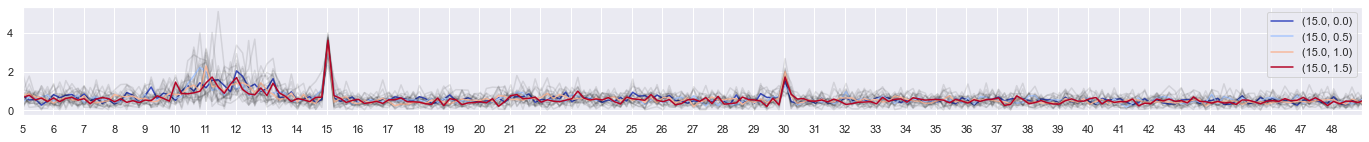

In [19]:
psd = 1/750*np.abs(fft(eeg))[:,:,:,:int(sfreq*duration)//2]
freqs = np.linspace(0.0, sfreq / 2, int(sfreq*duration//2))
colors=cm.coolwarm(np.linspace(0,1,4))
for i,c in enumerate(colors):
    if i % 4 == 0:
        plt.figure(figsize=(24, 2))
        plt.xticks(range(5,49));
        ax = plt.subplot()
        ax.set_xlim(5, 49)
        # ax.set_ylim(0, 40)
    for j in range(psd.shape[0]):
        sns.lineplot(x=freqs, y=psd[j,i,0,:], ax=ax,color='black', alpha = 0.1)
    sns.lineplot(x=freqs, y=psd[:,i,0,:].mean(axis=0), ax=ax, label=str(list(target_tab.keys())[i]),color=c)

In [164]:
sub_dirs = ['8hz/','9hz/','10hz/','11hz/','12hz/','13hz/','14hz/','15hz/']
duration = 5

# load experimental dataset
eeg_whole = np.zeros((5,32,7,1500))
target_tab = {}
i_class = 0
for i_dir,sub_dir in enumerate(sub_dirs):

    data_path = "../data/eeg_recordings/pilot_data/simon/ws32_6/" + sub_dir
    eeg = pd.read_csv(data_path + 'eeg.csv').astype(float)
    meta = np.loadtxt(data_path + 'meta.csv', delimiter=',', dtype=float)
    trials = meta[1:,:2]
    classes = np.unique(trials, axis=0)
    more_targets = {tuple(target):index+i_class for index,target in enumerate(classes)}
    target_tab.update(more_targets)
    eeg = load_data_temp_function(eeg, meta, classes, stim_duration=duration,filter=False)
    eeg_whole[:,i_class:(i_class+4),:,:] = eeg
    i_class+=4
eeg = eeg_whole
target_by_trial = [list(target_tab.keys())] * 5
eeg.shape, np.array(target_by_trial).shape # 36 classes due to having an additional 12.6hz

((5, 32, 7, 1500), (5, 32, 2))

In [160]:
y = np.array([list(target_tab.values())] * 5).T.reshape(-1)
eeg_temp = eeg[:,:,:,40:]
# X = eeg.swapaxes(0,1).reshape(-1,*eeg.shape[2:])
X = eeg_temp.swapaxes(0,1).reshape(-1,*eeg_temp.shape[2:])

freq_targets = np.array(target_by_trial)[0,:,0]
phase_targets = np.array(target_by_trial)[0,:,1]
n_harmonics = 5
n_bands = 3
srate = 300
duration = 0.5
Yf = generate_cca_references(
    freq_targets, srate, duration, 
    phases=phase_targets, 
    n_harmonics=n_harmonics)
wp = [[8*i, 90] for i in range(1, n_bands+1)]
ws = [[8*i-2, 95] for i in range(1, n_bands+1)]
filterbank = generate_filterbank(
    wp, ws, srate, order=4, rp=1)
filterweights = np.arange(1, len(filterbank)+1)**(-1.25) + 0.25
set_random_seeds(64)
l = 5
models = OrderedDict([
    # ('fbscca', FBSCCA(
    #         filterbank, filterweights=filterweights)),
    # ('fbecca', FBECCA(
    #         filterbank, filterweights=filterweights)),
    ('fbdsp', FBDSP(
            filterbank, filterweights=filterweights)),
    ('fbtrca', FBTRCA(
            filterbank, filterweights=filterweights)),
    ('fbtdca', FBTDCA(
            filterbank, l, n_components=8, 
            filterweights=filterweights)),
])
events = []
for j_class in range(32):
    events.extend([str(target_by_trial[i_trial][j_class]) for i_trial in range(5)])
events = np.array(events)
subjects = ['1'] * (32*5)
meta = pd.DataFrame(data=np.array([subjects,events]).T, columns=["subject", "event"])
set_random_seeds(42)
loo_indices = generate_loo_indices(meta)

for model_name in models:
    if model_name == 'fbtdca':
        filterX, filterY = np.copy(X[..., :int(srate*duration)+l]), np.copy(y)
    else:
        filterX, filterY = np.copy(X[..., :int(srate*duration)]), np.copy(y)
    
    filterX = filterX - np.mean(filterX, axis=-1, keepdims=True)

    n_loo = len(loo_indices['1'][events[0]])
    loo_accs = []
    for k in range(n_loo):
        train_ind, validate_ind, test_ind = match_loo_indices(
            k, meta, loo_indices)
        train_ind = np.concatenate([train_ind, validate_ind])

        trainX, trainY = filterX[train_ind], filterY[train_ind]
        testX, testY = filterX[test_ind], filterY[test_ind]

        model = clone(models[model_name]).fit(
            trainX, trainY,
            Yf=Yf
        )
        pred_labels = model.predict(testX)
        loo_accs.append(
            balanced_accuracy_score(testY, pred_labels))
    print("Model:{} LOO Acc:{:.2f}".format(model_name, np.mean(loo_accs)))

Model:fbdsp LOO Acc:0.15
Model:fbtrca LOO Acc:0.18
Model:fbtdca LOO Acc:0.23


In [62]:
import pickle 
with open("../reports/trained_models/s32/fbtdca_2s.pkl", 'wb') as filehandler:
    pickle.dump(model, filehandler)

In [9]:
import pickle 
with open("../reports/trained_models/s32/fbtdca_2s.pkl", 'rb') as filehandler:
    loaded_model = pickle.load(filehandler)

In [ ]:
import pickle 
file_pi2 = open('filename_pi.obj', 'r') 
object_pi2 = pickle.load(file_pi2)

In [168]:
model.predict(eeg[2,:,:,40:200])

array([29, 22, 21,  6,  4, 11,  3, 15, 15, 13, 12,  8, 12,  3, 10, 15, 16,
        9, 18, 26, 16, 21, 15, 14, 20, 12, 26,  4,  9, 20, 27, 19])

In [57]:
eeg.shape

(5, 32, 7, 1500)

In [25]:
X.shape

(160, 7, 1460)

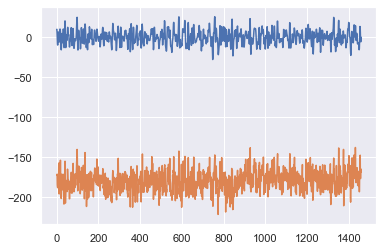

In [49]:
plt.plot(X[2,0])
plt.plot(eeg[2,0,0,40:])

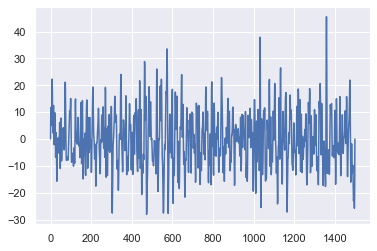

In [29]:
model.predict(X[3])

array([0])

In [7]:
testX[0].shape

(7, 605)

In [13]:
loaded_model.predict(testX[10,:,:605])

array([10])

In [52]:
y[50]

10